Creation of Low Rank Environment

In [1]:
import numpy as np
from scipy.stats.distributions import norm
from scipy.special import softmax
from tqdm import tqdm


class SimplexEnvironment:
    def __init__(self, states=100, actions=20, bell_rank=10):
        self.S = states
        self.A = actions
        self.d = bell_rank
        self.initial_distrib = self.unif_over_states

        self.P = softmax(np.random.uniform(low=-self.d, high=self.d, size=(self.S, self.A, self.d)) , axis=2)
        # x = np.random.uniform(low=-self.d, high=self.d, size=(self.S, self.A, self.d))
        # e_x = np.exp(x - np.tile(np.max(x, axis=2).reshape(-1, 2, 1), (1,1,self.d)))
        # self.P = e_x / np.tile(np.sum(e_x, axis=2).reshape(-1, 2, 1), (1,1,self.d))


        self.U = softmax(np.random.uniform(-self.d, self.d, (self.S, self.d)), axis=0)
        # x = np.random.uniform(-self.d, self.d, (self.S, self.d))
        # e_x = np.exp(x - np.tile(np.max(x, axis=0), (self.S, 1)))
        # self.U = e_x / np.sum(e_x, axis=0)
    
    
    def Phi(self, s, a):
        return self.P[s, a, :]
    
    def Mu(self, s):
        return self.U[s, :].T # s entre 0 y S-1 

    def T(self, s, a, s_):
        return np.dot(self.Phi(s, a), self.Mu(s_))

    def unif_over_states(self, states=100):
        return np.random.randint(low=0, high=states)

    def unif_over_actions(self, current_state, actions):
        return np.random.randint(low=0, high=actions)

    def next_step_distrib(self, s, a):
        return np.dot(self.Phi(s,a), self.U.T)

    def next_step_state(self, s, a):
        return np.random.choice(self.S, p=self.next_step_distrib(s,a))
    
    def next_step_reward(self, s, a):
        return norm.rvs()
    
    def next_step(self, s, a):
        """ 
        Gives the next state and reword for the given actions. 
        If `s` is the absorving state (i.e s == self.S - 1. Just by convention)
        Then this will return 0 as reward and a state following the initial state distrib.
        """
        if s == self.S - 1:
            return self.first_step(), 0
        else:
            return self.next_step_state(s, a), self.next_step_reward(s, a)
    
    def first_step(self):
        return self.initial_distrib(self.S)
    
    def get_transitions(self):
        transitions = []
        for a in tqdm(range(self.A)):
            transitions.append([self.P[:, a, :] @ self.U.T])
        return np.vstack(transitions)
        
    def simulate_n_steps(self, n):
        path = []
        prev_s = self.first_step()

        for _ in tqdm(range(n), desc=f"Simulating {n} Steps"):
            a = self.unif_over_actions(prev_s, self.A)
            s = self.next_step_state(prev_s, a)
            path.append((prev_s, a, s))
        
        return path

    def simulate_n_steps_policy(self, n, policy):
        path = []
        prev_s = self.first_step()

        for _ in tqdm(range(n), desc=f"Simulating {n} Steps and custom policy"):
            a = policy(prev_s, self.A)
            s = self.next_step_state(prev_s, a)
            path.append((prev_s, a, s))
        
        return path

    def simulate_n_steps_rewards(self, n):
        path = []
        prev_s = self.first_step()

        for i in tqdm(range(n), desc=f"Simulating {n} Steps with rewards"):
            a = self.unif_over_actions(prev_s, self.A)
            s, r = self.next_step(prev_s, a)
            path.append((prev_s, a, s, r))
        
        return path

    def simulate_n_steps_rewards_policy(self, n, policy=None):
        path = []
        prev_s = self.first_step()

        for i in tqdm(range(n), desc=f"Simulating {n} Steps with rewards and custom policy"):
            a = policy(prev_s, self.A)
            s, r = self.next_step(prev_s, a)
            path.append((prev_s, a, s, r))
        
        return path
            


sGS-ADMM Definition

In [2]:
from tqdm import tqdm
from scipy.stats import ortho_group, uniform
from scipy.linalg import svd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt
sns.set_theme()


def sGS_ADMM(p, D, penalty = 10, c = 0.1, iter_number = 100, step_len = 0.2, M = None):
    """
    # Parameters:
    p: Number of States of the Process
    D: List-like with state-state transitions (s_i, s_{i+1}) where s_i \in {0, ..., S-1}, S being the number of states of the Markov Chain.
    M: Real Transition Kernel, Optional. Only Passed if it is required to calculate how good the alg computes its estimator in Fb norm.
    """
    n = len(D)
    N = np.zeros((p, p))
    for i, j in D: # Counting State transitions
        N[i, j] += 1
    
    # Calculate MLE Estimator for the transition Kernel of the Markov Process
    mle = np.zeros((p, p))

    for i in tqdm(range(p), desc="Calculating MLE"):
        row_sum = np.sum(N[i,:])
        if(row_sum > 0):
            mle[i, :] = N[i, :] / row_sum
        else:
            mle[i, :] = 1 / p

    np.random.seed(0)
    b = np.ones(shape=(p, 1))


    def AstarFunc(y):
        return np.hstack([y.reshape(-1, 1)]*p)

    def AFunc(M):
        return M @ b

    #Starting point is the MLE for this problem
    S = ortho_group.rvs(p) @ np.diag(uniform.rvs(size=p) * c) @ ortho_group.rvs(p).T # random matrix with 0 < spectral norm < c. 
    X = mle
    Xi = -(S + AstarFunc(np.random.rand(p, 1)))

    # Functions for Computation

    def computeY(Xi, S, X):
        y = (1 / (penalty * p)) * (b - penalty*AFunc(Xi + S + (1/penalty)* X))
        return y

    index = np.copy(N)
    index[index != 0] = 1 # All nonzero entries of our transition state counts are convert into 1
    not_index = - (index - 1)

    def computeXi(y, S, X):
        R = AstarFunc(y) + S + X * (1 / penalty)
        Z = penalty * (index * 0.5 * (R + np.sqrt(R ** 2 + 4 * N / (n * penalty))) + not_index * np.maximum(R, 0) )
        return (1 / penalty) * (Z - penalty * R)
        

    def computeS(Xi, y, X):
        W = -(Xi + AstarFunc(y) + (X / penalty))
        U, sing_vals, Vh = svd(W, full_matrices=False) # Computes de partial SVD of W
        return U @ np.diag(np.minimum(sing_vals, c)) @ Vh

    norm_diff = []

    for _ in tqdm(range(iter_number), desc="Running sGS_ADMM"):
        yk1_2 = computeY(Xi, S, X)
        # print(yk1_2.shape)
        Xi = computeXi(yk1_2, S, X)
        yk1 = computeY(Xi, S, X)
        S = computeS(Xi, yk1, X)
        X = X + step_len * penalty * (Xi + AstarFunc(yk1) + S)

        if M is not None:
            norm_diff.append(np.linalg.norm((X-M), ord='fro'))

    if M is not None:
        fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4.5),
                        constrained_layout=True)
    
        axs[0].plot(norm_diff) 
        axs[0].set_ylabel("$||X - M||_{fb}$")
        axs[0].set_xlabel("Number of iterations")
        axs[0].set_title(f"$\sigma={penalty}, \gamma = {step_len}, c = {c}$")


        axs[1] = heatmap(M)
        axs[1].set_title("Heat Map of Estimator")
        return X, norm_diff
    else:
        return X


### Simluate Random Markov Chain

In [3]:
p = 1000
r = 10
states = [i for i in range(p)]
U = np.random.standard_normal(size=(p, r))
V = np.random.standard_normal(size=(p, r))

def normalizeMatrix(H, axis=1):
    axis_sum =  np.sum(H, axis=axis)
    if axis:
        return np.divide(H, axis_sum.reshape(-1, 1))
    else:
        return np.divide(H, axis_sum.reshape(1, -1))


U1 = normalizeMatrix(U * U) # Row-wise normalization of the Hadamard product of U with itself
V1 = normalizeMatrix(V * V, axis = 0) #Column-wise normalization of Hadamard product of V with itself

M = U1 @ V1.transpose()

In [4]:
from tqdm import tqdm
n = round(15 * p * np.log(p))
prev_state = np.random.choice(states)
path = []
for i in tqdm(range(n)):
    current_state = np.random.choice(states, p = M[prev_state])
    path.append((prev_state, current_state))
    prev_state = current_state

100%|██████████| 103616/103616 [00:12<00:00, 8337.18it/s]


Running sGS_ADMM: 100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


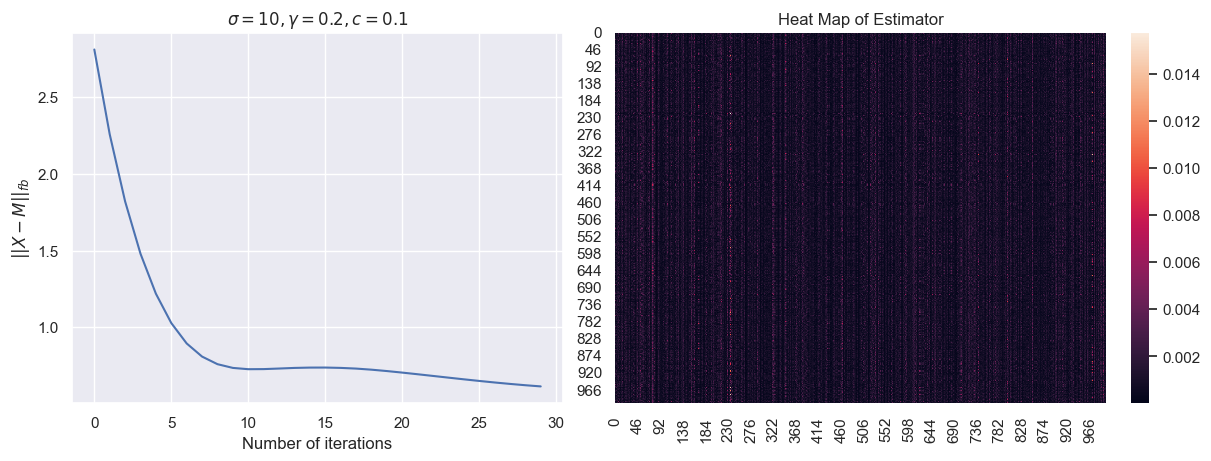

In [5]:
_,_ = sGS_ADMM(p, path, M = M, iter_number=30)

## MDP_sGS_ADMM

This will be the same algorithm as before but know it will be runned once for every possible action in the MDP. As Python for loops are quite slow, the implementation will just be almost the same as before but using `batches` of matrices, so the operations are done in parallel. In this sense, the code below is almost identical at the original sGS-ADMM implemmentation, but using PyTorch tensors, since this library has a lot of functions built to support list of matrices, or batches of matrices and it automagically parallelizes de work in the CPU or GPU.

In [17]:
from tqdm import tqdm
from scipy.stats import ortho_group, uniform
from scipy.linalg import svd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt
sns.set_theme()
import torch


def sGS_ADMM_MDPs(p, a, D, penalty = 10, c = 0.1, iter_number = 100, step_len = 0.2, M = None, N=None, mle = None):
    """
    # Parameters:
    p: Number of States of the Process
    a: Number of Actions
    D: List-like with state-state transitions (s_i, a,  s_{i+1}) where s_i \in {0, ..., S-1}, S being the number of states of the Markov Chain.
    M: Batch of Real Transition Kernel, Optional. Only Passed if it is required to calculate how good the alg computes its estimator in Fb norm. 
    Should be a `torch.Tensor` of shape (a, p, p).
    N: (a x p x p) tensor with batch of matrices that have transition counts from state to state
    mle: (a x p x p) tensor with batch of matrices that have the mle of the real distrib
    """
    n = len(D)

    if N is None:
        N = torch.zeros((a, p, p), dtype=torch.float32)
        for i, action, j in D: # Counting State transitions
            N[action, i, j] += 1
    
    if mle is None:
    # Calculate MLE Estimator for the transition Kernel of the Markov Process
        mle = torch.zeros(N.size(), dtype=torch.float32)

        for i in tqdm(range(a), desc=f"Calculating MLE for {a} Matrices"):
            for j in range(p):
                row_sum = torch.sum(N[i, j,:])
                if(row_sum > 0):
                    mle[i, j, :] = N[i, j, :] / row_sum
                else:
                    mle[i, j, :] = 1 / p
          
    np.random.seed(0)
    torch.manual_seed(0)
    b = torch.ones(size=(a, p, 1), dtype=torch.float32)


    def AstarFunc(y):
        return torch.cat([y]*p, dim=2)

    
    def AFunc(M):
        return torch.bmm(M, b)

    # Starting point is the MLE for this problem
    S = torch.from_numpy((ortho_group.rvs(p) @ np.diag(uniform.rvs(size=p) * c) @ ortho_group.rvs(p).T)).repeat(a, 1, 1).to(torch.float32) # random matrices with 0 < spectral norm < c. 
    X = mle
    Xi = -(S + AstarFunc(torch.rand((a, p, 1), dtype=torch.float32)))

    # Functions for Computation
    def computeY(Xi, S, X):
        y = (1 / (penalty * p)) * (b - penalty * AFunc(Xi + S + (1/ penalty) * X))
        return y
    
    index = N.detach()
    index[index != 0] = 1 # All nonzero entries of our transition state counts are convert into 1
    not_index = - (index - 1)

    def computeXi(y, S, X):
        R = AstarFunc(y) + S + X * (1 / penalty)
        Z = penalty * (index * 0.5 * (R + torch.sqrt(R ** 2 + 4 * N / (n * penalty))) + not_index * torch.maximum(R, torch.tensor(0)) )
        return (1 / penalty) * (Z - penalty * R)
        

    def computeS(Xi, y, X):
        W = -(Xi + AstarFunc(y) + (X / penalty))
        U, sing_vals, Vh = torch.linalg.svd(W, full_matrices=False) # Computes de partial SVD of W 
        return U @ torch.diag_embed(torch.minimum(sing_vals, torch.tensor(c))) @ Vh

    norm_diff = []

    for _ in tqdm(range(iter_number), desc="Running sGS_ADMM"):
        yk1_2 = computeY(Xi, S, X)
        Xi = computeXi(yk1_2, S, X)
        yk1 = computeY(Xi, S, X)
        S = computeS(Xi, yk1, X)
        X = X + step_len * penalty * (Xi + AstarFunc(yk1) + S)

        if M is not None:
            norm_diff.append(torch.sum(torch.linalg.matrix_norm((X-M))))

    if M is not None:
        fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12, 4.5),
                        constrained_layout=True)
    
        axs.plot(norm_diff) 
        axs.set_ylabel("$\sum_{a \in \mathcal{A}}||X_a - M_a||_{fb}$")
        axs.set_xlabel("Number of iterations")
        axs.set_title(f"$\sigma={penalty}, \gamma = {step_len}, c = {c}$")
        return X, norm_diff
    else:
        return X



Running sGS_ADMM: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


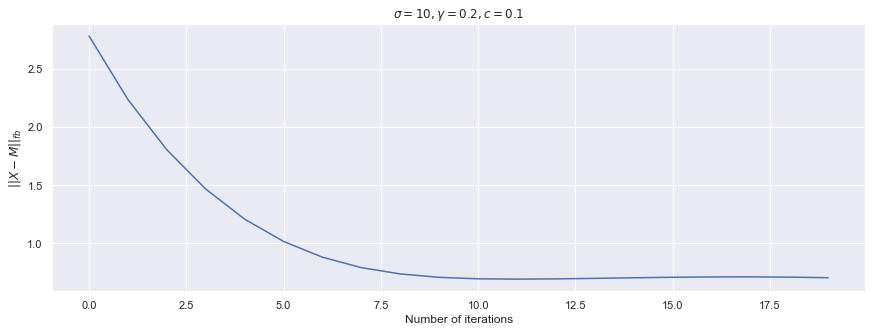

In [161]:
tensor_M = torch.from_numpy(M).unsqueeze(0)
mdp_path = [(s1, 0, s2) for (s1, s2) in path]
_,_ = sGS_ADMM_MDPs(p, 1, mdp_path, M = tensor_M, iter_number=20)

### Simulate MDP Process with $a \cdot r \cdot p log(p)$ samples. Using an exploratory policy uniform over actions

In [223]:
MDP = SimplexEnvironment(states=1000, actions=10, bell_rank=10)
t = torch.from_numpy(MDP.get_transitions()).to(torch.float32)

100%|██████████| 10/10 [00:00<00:00, 541.14it/s]


In [224]:
t.size()

torch.Size([10, 1000, 1000])

In [225]:
from math import ceil
n = ceil(MDP.A * MDP.d * MDP.S * np.log(MDP.S))
path = MDP.simulate_n_steps(n)

100%|██████████| 690776/690776 [00:38<00:00, 18127.87it/s]


Running sGS_ADMM: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


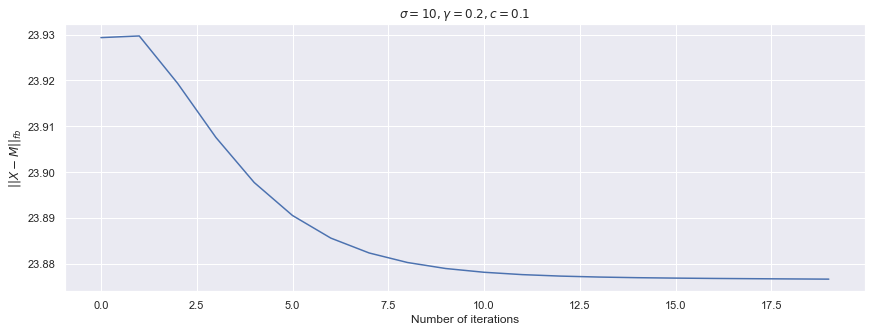

In [226]:
X, diff = sGS_ADMM_MDPs(MDP.S, MDP.A, path, M = t, iter_number=20)

Running sGS_ADMM: 100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


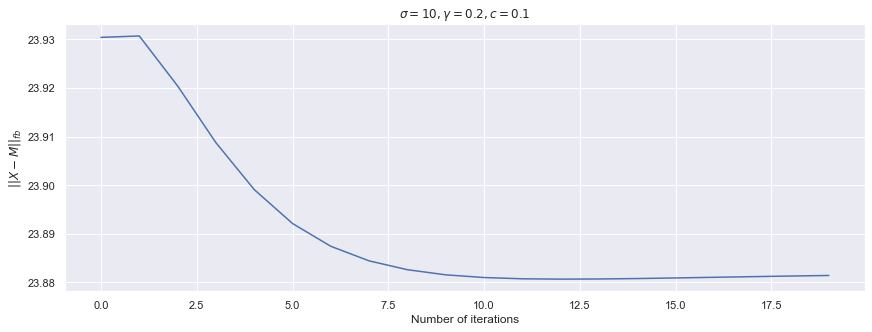

In [227]:
n = 20*ceil(MDP.A * MDP.d * MDP.S * np.log(MDP.S))
path = MDP.simulate_n_steps(n)
X, diff = sGS_ADMM_MDPs(MDP.S, MDP.A, path, M = t, iter_number=20)


### Creating Environments

Know for experimentation purposes we will create a somewhat big MDP and a Big sample over that MDP. This is because simulating a walk on Python is really slow, so to make experiments we will just use this big sample as our Dataset. 

In [7]:
MDP = SimplexEnvironment(states=1000, actions=100, bell_rank=10)

In [17]:
from pickle import dump
import os 
dump(MDP, open( os.path.join("data", "MDP_1.bin"), "wb" ))

In [9]:
from pickle import load
MDP = load(open( os.path.join("data", "MDP_1.bin"), "rb" ))

In [21]:
t = torch.from_numpy(MDP.get_transitions()).to(torch.float32)

100%|██████████| 100/100 [00:00<00:00, 354.61it/s]


In [15]:
%%time
from math import ceil
n = 30*ceil(MDP.A * MDP.d * MDP.S * np.log(MDP.S))
path = MDP.simulate_n_steps(n)

Simulating 207232680 Steps: 100%|██████████| 207232680/207232680 [2:53:01<00:00, 19962.64it/s]  

CPU times: total: 2h 51min 16s
Wall time: 2h 53min 1s


In [18]:
dump(path, open( os.path.join("data", "MDP_1_data.bin"), "wb" ))

In [12]:
path = load(open( os.path.join("data", "MDP_1_data.bin"), "rb" ))


Running sGS_ADMM: 100%|██████████| 20/20 [05:56<00:00, 17.83s/it]


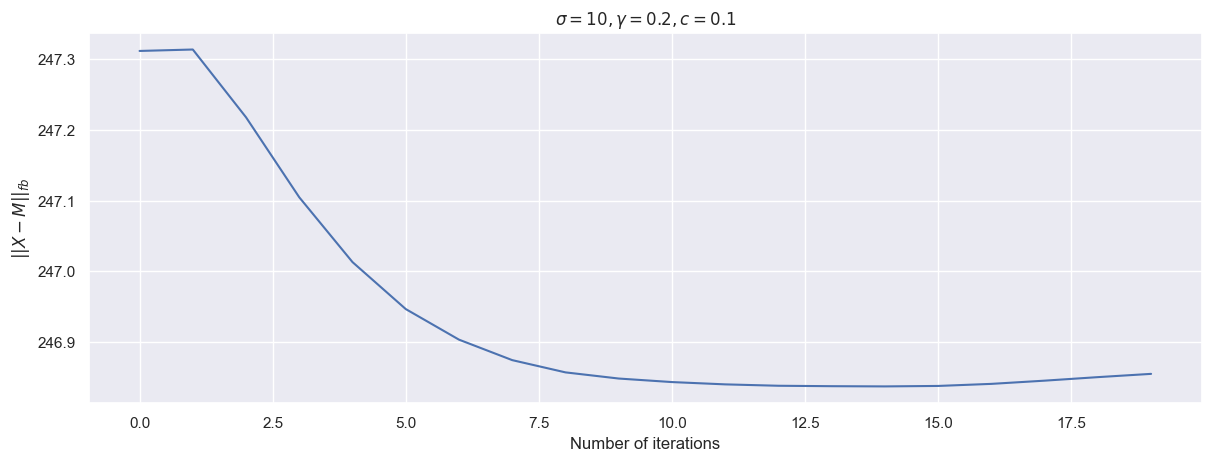

In [22]:
X, diff = sGS_ADMM_MDPs(MDP.S, MDP.A, path[0:50_000_000], M = t, iter_number=20)

Trying different parameters

Running sGS_ADMM: 100%|██████████| 20/20 [06:33<00:00, 19.68s/it]


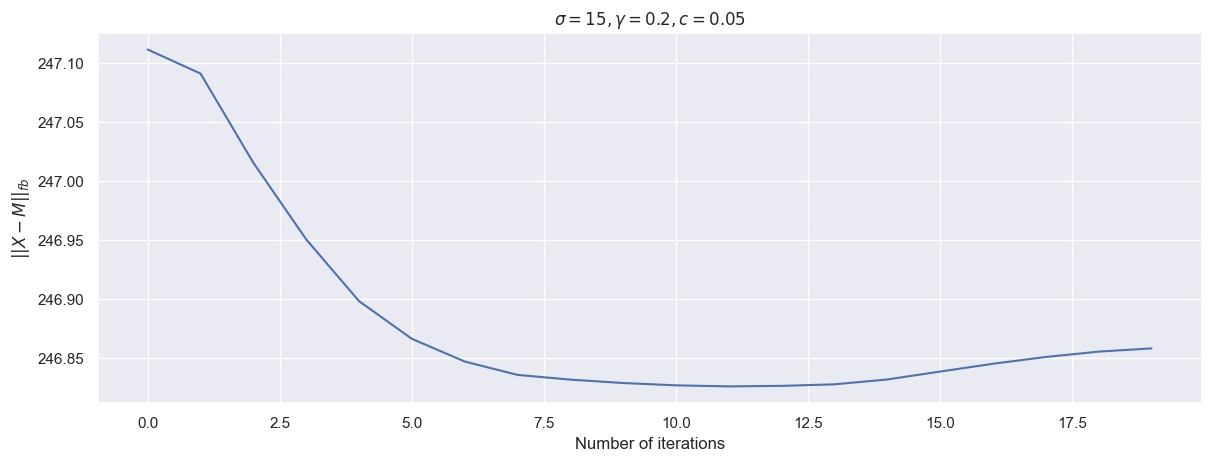

In [25]:
X, diff = sGS_ADMM_MDPs(MDP.S, MDP.A, path[0:50_000_000], M = t, iter_number=20, penalty=15, c=0.05)

## sGD-ADMM on DataSet

Lets run this for our small training dataset

Running sGS_ADMM: 100%|██████████| 40/40 [00:00<00:00, 138.89it/s]


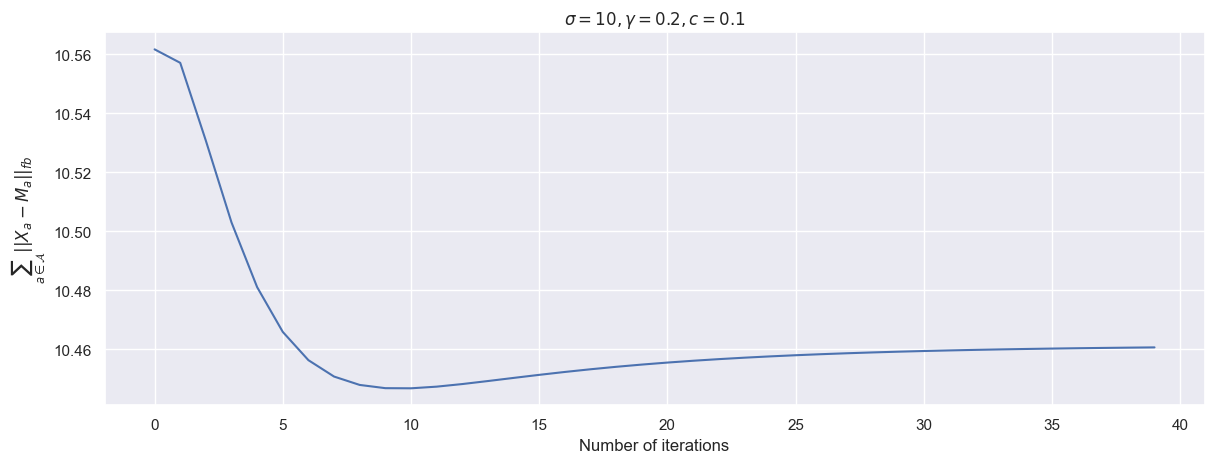

In [21]:
from pickle import load
import os
import torch
from utils import SimplexEnvironment
import numpy as np


MDP = load(open(os.path.join("data", "mdps", "small" ,"small_mdp.bin"), 'rb'))
train_path = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_path_train.bin"), 'rb'))
t = MDP.get_transitions()
X, diff = sGS_ADMM_MDPs(MDP.S, MDP.A, train_path, M = t, iter_number=40, penalty=10, c=0.1)
plt.savefig("./images/small_mdp_sgadmm_fb_diff.pdf",format="pdf", bbox_inches="tight")

Optimal Value Function and Policy

In [12]:
%%time
from utils import PolicyIteration
import numpy as np

MDP = load( open(os.path.join("data", "mdps", "small" ,"small_mdp.bin"), 'rb'))


def reward(s_prev, a, s_next):
    return np.log(s_prev + 1) + np.log(a + 1) + np.log(s_next + 1)

def next_state_prob(s, a):
    return X.numpy()[a, s, :]

pol_iter = PolicyIteration(MDP.S , MDP.A, next_state_prob , reward)

v, pol = pol_iter.run()

  0%|          | 1/2000 [00:00<00:06, 333.01it/s]

CPU times: total: 0 ns
Wall time: 10 ms


In [13]:
from pickle import load

v_true, pol_true = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_optimals.bin"), 'rb'))

np.mean(np.abs(v - v_true))

0.04312533571619261

Max Value for Real Value Function

In [16]:
np.max(v)

10.06392301596133